# Assignment 4: Generative Models

Welcome to the final assignment for CS163 Computer Vision course!

Congratulations that you have made it this far and best of luck with the final exams! Let's see what you will accomplish in this last challenge. As always, if you have any questions or concerns, please don't hesitate to reach out to the course staff. We are here to support you throughout the process.

Before we get started, please type your information below.

In [ ]:
#@title Your Info { display-mode: "form" }

Name = ''  #@param {type:"string"}
UID = ''  #@param {type:"string"}

## Goals


In this assignment, you will have the opportunity to explore three popular generative models for different applications:

1. Autoregressive Models and RNNs
2. Diffusion Models


Through this assignment, you will be building an image-captioning model that generates text descriptions given image inputs and visualizes the attention weights. You will also gain experience in building a diffusion model to generate images and understanding the state-of-the-art StableDiffusion text-to-image diffusion model. 

As always, please feel free to post any questions or issues you encounter on the Piazza forum. And remember, please do not directly copy code from other sources.

This assignment is due on ***Sunday, Dec 7***. Best of luck with your work!

❗**Once you have finished all the questions, note that it may take approximately *60 minutes* to re-run the entire notebook to prepare the submission version. Make sure to allocate enough time for this task and start early.**

## Q0: Data Preparation(0 pts)

In [ ]:
# Import all the common packages, you can just rerun this cell if you restart the kernel and found some packages are missing
# It is also good for you to get familiar with these packages
import cv2 # defines functions for computer vision tasks
import matplotlib.pyplot as plt # defines functions for plotting
import numpy as np # defines functions for manipulating arrays
import os # defines operating system related functions
import random # defines functions for generating random numbers
import torch # defines functions for tensor computations
import torch.nn as nn # defines modules for building neural networks
import torch.nn.functional as F # defines functions for building neural networks
from PIL import Image  # defines the Python Imaging Library (Pillow) for image processing
from torchvision import transforms # defines functions for image transformations
from torch.utils.data import DataLoader, Dataset # defines functions for data loading and dataset handling
from tqdm import tqdm # defines functions for displaying progress bars

### Setup Seeding

In [ ]:
# Also, seed everything for reproducibility
# code from https://gist.github.com/ihoromi4/b681a9088f348942b01711f251e5f964#file-seed_everything-py
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


seed_everything(0)

### Setup Device

In [ ]:
# Define the device to use for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

In [ ]:
!nvidia-smi

### Create Folder

In [ ]:
# Let's make our assignment directory
CS163_path = './CS163_F25'
os.makedirs(CS163_path, exist_ok=True)
# os.makedirs will create directories recursively, i.e., it will create the
# directories and any missing parent directories if they do not exist.

----
## Q1. Autoregressive Model (50 pts)
In this exercise, you will implement image captioning with RNNs and attention to train a model that can generate natural language captions for images. Recall the high-level architecure below discussed in the lecture:

 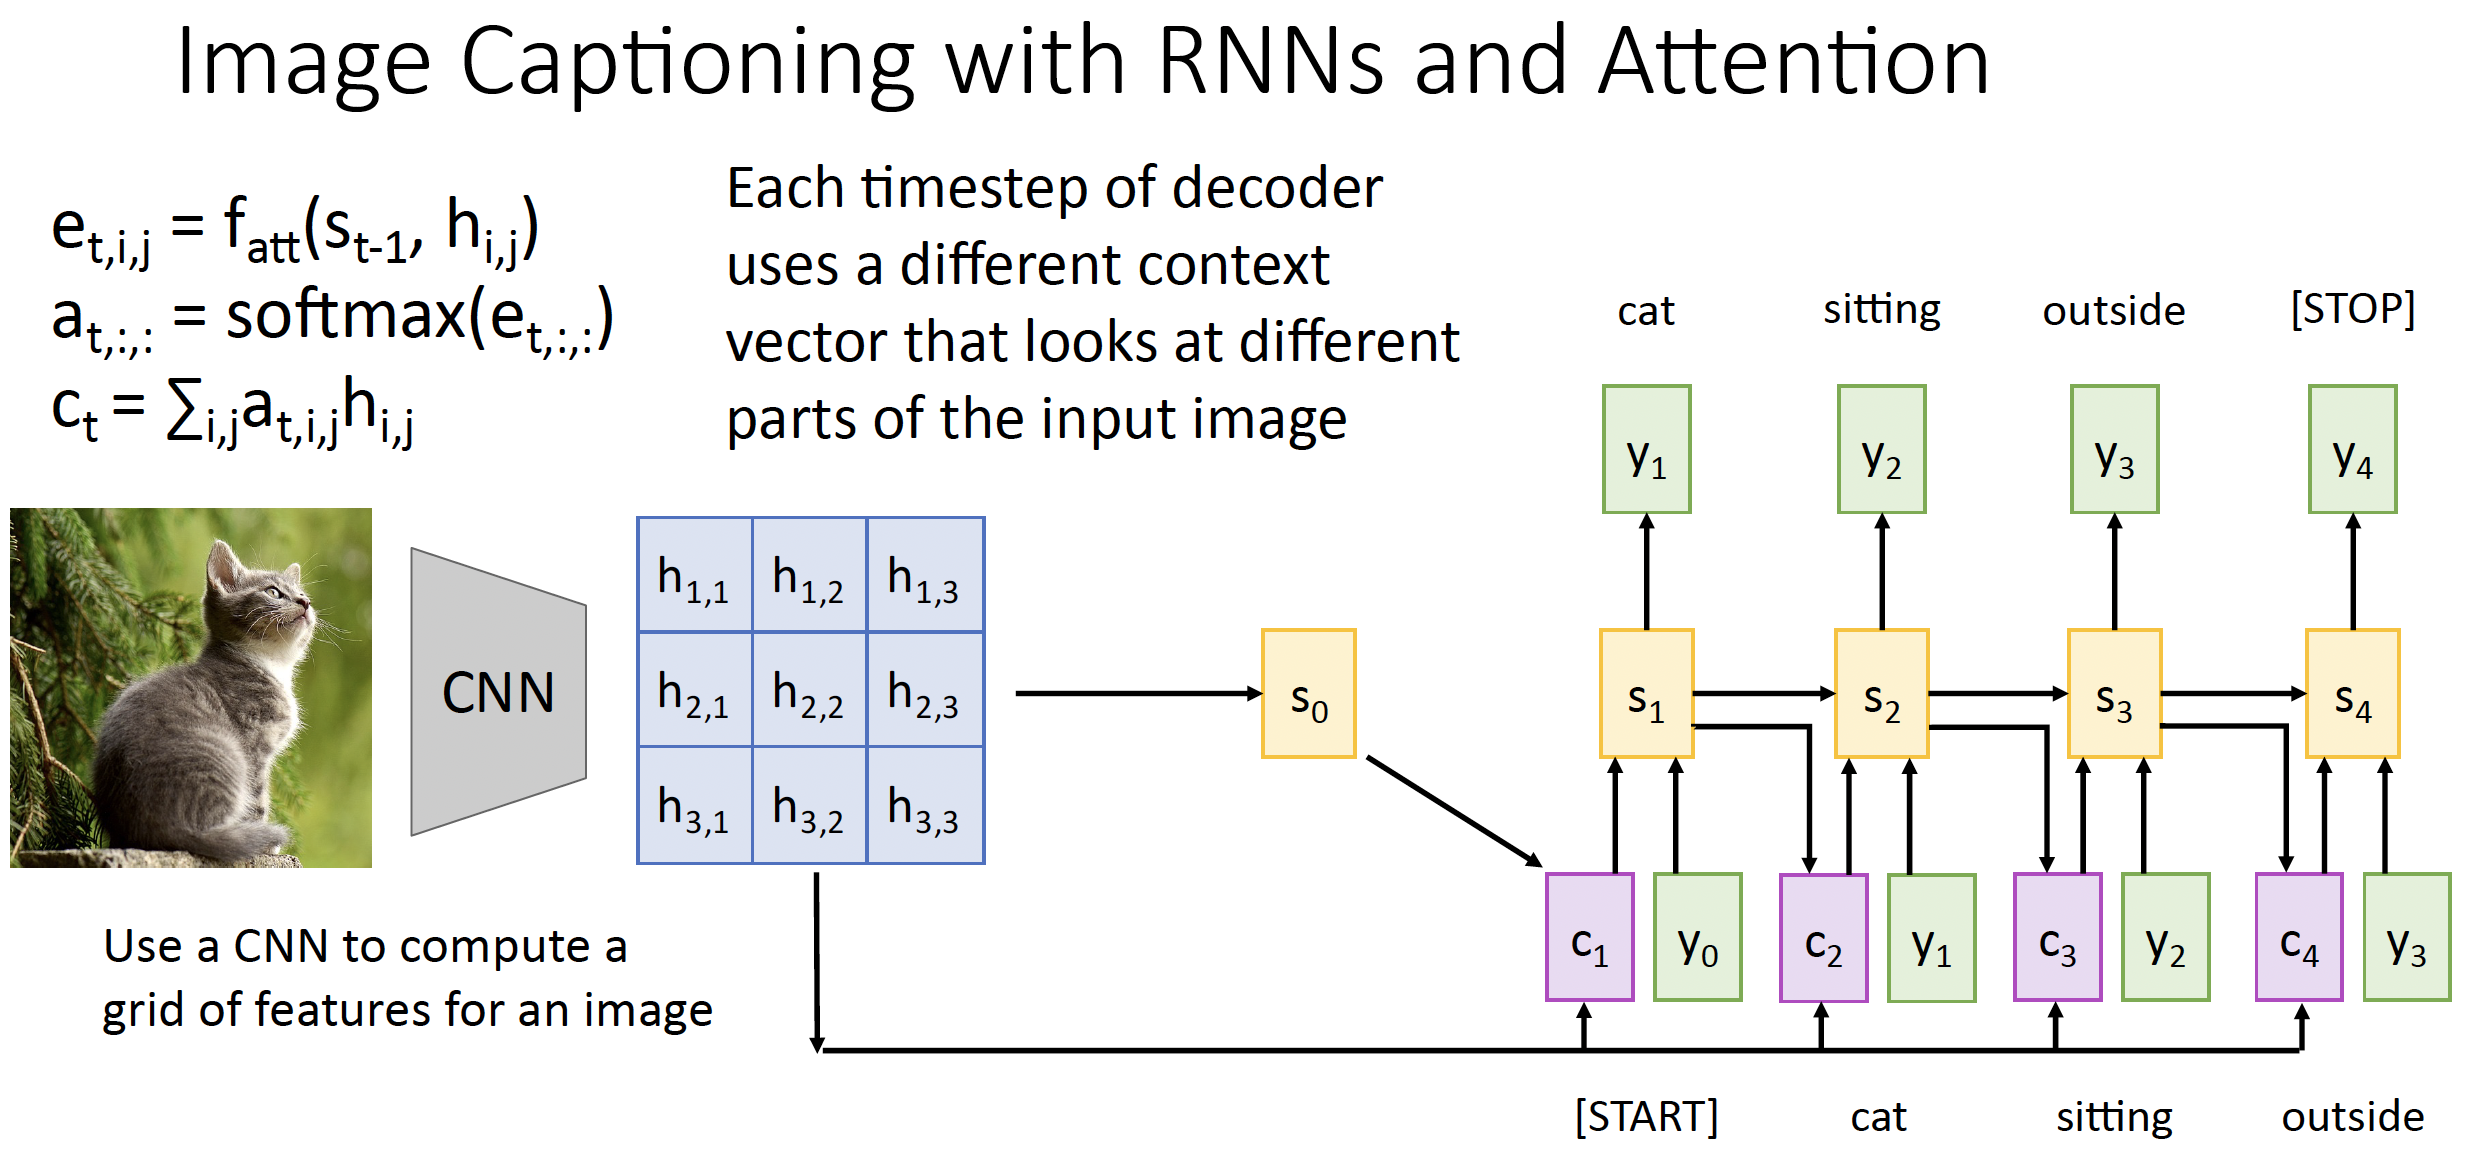



Models in this exercise are highly similar to very early works in neural-network based image captioning. If you are interested to learn more, check out these two papers:

1. [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/abs/1411.4555)
2. [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)

A large part of this exercise is adapted from [EECS498](https://web.eecs.umich.edu/~justincj/teaching/eecs498/WI2022/assignment5.html) from UMich by Prof. Justin Johnson.


### COCO Captions

For this exercise we will use the 2014 release of the [COCO Captions dataset](http://cocodataset.org/) which has become the standard testbed for image captioning. The dataset consists of 80,000 training images and 40,000 validation images, each annotated with 5 captions written by workers on Amazon Mechanical Turk.

We have preprocessed the data for you already and saved them into a serialized data file. It contains 10,000 image-caption pairs for training and 500 for testing. The images have been downsampled to 112x112 for computation efficiency and captions are tokenized and numericalized, clamped to 15 words. You can download the file named `coco.pt` (378MB) with the link below:

In [ ]:
!wget -O coco.pt https://ucla.box.com/shared/static/a90rzvduxdvvczvth1c0eiusqft27b6g.pt

A few notes on the caption preprocessing:

Dealing with strings is inefficient, so we will work with an encoded version of the captions. Each word is assigned an integer ID, allowing us to represent a caption by a sequence of integers. The mapping between integer IDs and words is saved in an entry named `vocab` (both `idx_to_token` and `token_to_idx`), and we use the function `decode_captions` to convert tensors of integer IDs back into strings.

There are a couple special tokens that we add to the vocabulary. We prepend a special `<START>` token and append an `<END>` token to the beginning and end of each caption respectively. Rare words are replaced with a special `<UNK>` token (for "unknown"). In addition, since we want to train with minibatches containing captions of different lengths, we pad short captions with a special `<NULL>` token after the `<END>` token and don't compute loss or gradient for `<NULL>` tokens. Since they are a bit of a pain, we have taken care of all implementation details around special tokens for you.

In [ ]:
def load_coco_captions(path: str = "./coco.pt"):
    """
    Download and load serialized COCO data from coco.pt
    It contains a dictionary of
    "train_images" - resized training images (112x112)
    "val_images" - resized validation images (112x112)
    "train_captions" - tokenized and numericalized training captions
    "val_captions" - tokenized and numericalized validation captions
    "vocab" - caption vocabulary, including "idx_to_token" and "token_to_idx"

    Returns: a data dictionary
  """
    data_dict = torch.load(path)
    # print out all the keys and values from the data dictionary
    for k, v in data_dict.items():
        if type(v) == torch.Tensor:
            print(k, type(v), v.shape, v.dtype)
        else:
            print(k, type(v), v.keys())

    assert data_dict["train_images"].size(0) == data_dict["train_captions"].size(
        0
    ) and data_dict["val_images"].size(0) == data_dict["val_captions"].size(
        0
    ), "shapes of data mismatch!"

    print("\nTrain images shape: ", data_dict["train_images"].shape)
    print("Train caption tokens shape: ", data_dict["train_captions"].shape)
    print("Validation images shape: ", data_dict["val_images"].shape)
    print("Validation caption tokens shape: ", data_dict["val_captions"].shape)
    print(
        "total number of caption tokens: ", len(data_dict["vocab"]["idx_to_token"])
    )
    print(
        "mappings (list) from index to caption token: ",
        data_dict["vocab"]["idx_to_token"],
    )
    print(
        "mappings (dict) from caption token to index: ",
        data_dict["vocab"]["token_to_idx"],
    )

    return data_dict
# Download and load serialized COCO data from coco.pt
# It contains a dictionary of
# "train_images" - resized training images (IMAGE_SHAPE)
# "val_images" - resized validation images (IMAGE_SHAPE)
# "train_captions" - tokenized and numericalized training captions
# "val_captions" - tokenized and numericalized validation captions
# "vocab" - caption vocabulary, including "idx_to_token" and "token_to_idx"
# load COCO data from coco.pt
data_dict = load_coco_captions(path="./coco.pt")

num_train = data_dict["train_images"].size(0)
num_val = data_dict["val_images"].size(0)

# declare variables for special tokens
NULL_index = data_dict["vocab"]["token_to_idx"]["<NULL>"]
START_index = data_dict["vocab"]["token_to_idx"]["<START>"]
END_index = data_dict["vocab"]["token_to_idx"]["<END>"]
UNK_index = data_dict["vocab"]["token_to_idx"]["<UNK>"]

### Define the dataset

In [ ]:
class CocoCaptions(Dataset):
    def __init__(self, data_dict, split):
        """
        Initialize the CocoCaptions dataset with the loaded data_dict
        """
        assert split in ['train', 'val']
        if split == 'train':
            self.images = data_dict["train_images"]
            self.labels = data_dict["train_captions"]
        else:
            self.images = data_dict["val_images"]
            self.labels = data_dict["val_captions"]



    def __len__(self):
        """
        Return the number of images in the dataset.

        Returns:
            int: Number of images in the dataset.
        """
        return self.images.shape[0]
    def __getitem__(self, idx):
        """
        Return a single image and its corresponding label when given an index.

        Args:
            idx (int): Index of the image to retrieve.

        Returns:
            tuple: Tuple containing the image and its label.
        """
        image = self.images[idx]
        label = self.labels[idx]

        return image, label

train_dataset = CocoCaptions(data_dict, "train")
val_dataset = CocoCaptions(data_dict, "val")

### Visualize the data
It is always a good idea to look at examples from the dataset before working with it.

Run the following to sample a small minibatch of training data and show the images and their captions. Running it multiple times and looking at the results helps you to get a sense of the dataset.

Note that we decode the captions using the `decode_captions` function.

In [ ]:
def decode_captions(captions, idx_to_word):
    """
    Decoding caption indexes into words.

    Args:
        captions: Caption indexes in a tensor of shape (N, T).
        idx_to_word: Mapping from the vocab index to word.

    Returns:
        decoded: A sentence (or a list of N sentences).
    """
    singleton = captions.ndim == 1
    captions = captions[None] if singleton else captions

    decoded = []
    N, T = captions.shape
    for i in range(N):
        words = []
        for t in range(T):
            word = idx_to_word[captions[i, t]]
            if word != "<NULL>":
                words.append(word)
            if word == "<END>":
                break
        decoded.append(" ".join(words))

    if singleton:
        decoded = decoded[0]
    return decoded

# Sample a minibatch and show the reshaped 112x112 images and captions4
sample_idx = torch.randint(0, num_train, (4, ))
sample_images = data_dict["train_images"][sample_idx]
sample_captions = data_dict["train_captions"][sample_idx]
for i in range(4):
    plt.imshow(sample_images[i].permute(1, 2, 0))
    plt.axis("off")
    caption_str = decode_captions(
        sample_captions[i], data_dict["vocab"]["idx_to_token"]
    )
    plt.title(caption_str)
    plt.show()

### Image Feature Extraction

The first essential component in an image captioning model is an encoder that inputs an image and produces features for decoding the caption.
Here, we use a small [vit_b_32](https://docs.pytorch.org/vision/main/models/generated/torchvision.models.vit_b_32.html#torchvision.models.vit_b_32) model as the backbone so we can train in reasonable time on Colab, the same ViT backbone that we have used in the past assignment.

It accepts image batches of shape `(B, C, H, W)` and outputs image tokens `(B, N, C)` with `N=50`. Recall the first token is the `[CLS]` token representing the global image feature and the rest `49=7*7` tokens are local patch tokens for attention RNN to learn attention weights.

We use the implementation from torchvision and put a very thin wrapper module for our use-case.
You do not need to implement anything here — you should read and understand the module definition below.

In [ ]:
from torchvision import models
from torchvision.models import feature_extraction

class ImageEncoder(nn.Module):
    """
    ViT network that accepts images as input and outputs global and local features.
    This module serves as the image encoder in image captioning
    model. We will use a tiny vit_b_32 model that is initialized with
    ImageNet-pretrained weights from Torchvision library.
    """

    def __init__(self, pretrained: bool = True, freeze=True, verbose: bool = True):
        """
        Args:
            pretrained: Whether to initialize this model with pretrained weights
                from Torchvision library.
            verbose: Whether to log expected output shapes during instantiation.
        """
        super().__init__()
        self.vit = models.vit_b_32(pretrained=pretrained)
        self.transform = models.ViT_B_32_Weights.IMAGENET1K_V1.transforms()

        self.backbone = feature_extraction.create_feature_extractor(
            self.vit, return_nodes={"encoder.ln": "feat"}
        )

        # Torchvision models return global features by default.
        # Our attention-based models may require local patch features. So we
        # wrap the ViT with torchvision's feature extractor.

        # Pass a dummy batch of input images to infer output shape.
        dummy_out = self.backbone(torch.randn(2, 3, 224, 224))["feat"]
        self._out_channels = dummy_out.shape[2]

        if freeze:
            for param in self.vit.parameters():
                param.requires_grad = False

        if verbose:
            print("For input images in BCHW format, shape (2, 3, 224, 224)")
            print(f"Shape of output features: {dummy_out.shape}")

    @property
    def out_channels(self):
        """
        Number of output channels in extracted image features. You may access
        this value freely to define more modules to go with this encoder.
        """
        return self._out_channels

    def forward(self, images: torch.Tensor):
        # Input images may be uint8 tensors in [0-255], change them to float
        # tensors in [0-1]. Get float type from backbone (could be float32/64).

        # Normalize images by ImageNet color mean/std.
        images = self.transform(images)

        # Extract features from encoder (backbone) and return.
        # shape: (B, out_channels, H / 32, W / 32)
        features = self.backbone(images)["feat"]
        return features

### Q1.1 AttentionRNN (15 pts)

Implement `AttentionRNN` by following its instructions and input specifications.

Recall at each timestep the *hidden state* $h\in\mathbb{R}^{H}$ in RNN cell is formulated as:

$h_{t}=\mathrm{tanh}(W_xx_t + W_hh_{t-1}+W_{attn}x_{attn}^t+b_h)$, where $x_t$ is the current input, $h_{t-1}$ is the last hidden state, and $x_{attn}$ is the attention vector.

$x_{attn}$ is computed from cross-attention where the query $Q$ is the last hidden state, while the key and value pair $(K, V)$ are from the local patch tokens.



In [ ]:
class AttentionRNN(nn.Module):
    """
    This is our single-layer, uni-directional Attention module.

    Args:
        input_dim: Input size, denoted as D before
        hidden_dim: Hidden size, denoted as H before
    """

    def __init__(self, input_dim: int, hidden_dim: int):
        """
        Initialize a RNN. Model parameters to initialize:
            Wx: Weights for input-to-hidden connections, of shape (D, H)
            Wh: Weights for hidden-to-hidden connections, of shape (H, H)
            Wattn: Weights for attention-to-hidden connections, of shape (H, H)
            b: Biases, of shape (H,)
        """
        super().__init__()

        ################# Your Implementations #################################
        # TODO: Implement the initialization of the attention RNN.
        self.Wx = None
        self.Wh = None
        self.Wattn = None
        self.b = None

        ################# End of your Implementations ##########################

    def step_forward(
        self,
        x: torch.Tensor,
        prev_h: torch.Tensor,
        attn: torch.Tensor,
    ) -> torch.Tensor:
        """
        Args:
            x: Input data for one time step, of shape (B, D)
            prev_h: The previous hidden state, of shape (B, H)
            attn: The attention embedding, of shape (B, H)

        Returns:
            next_h: The next hidden state, of shape (B, H)        """

        ################# Your Implementations #################################
        # TODO: Implement forward pass for a single timestep of attention RNN.

        next_h = None

        ################# End of your Implementations ##########################

        return next_h

    def forward(self, x: torch.Tensor, A: torch.Tensor):
        """
        Forward pass for an RNN over an entire sequence of data. We assume an
        input sequence composed of T vectors, each of dimension D. The RNN uses
        a hidden size of H, and we work over a minibatch containing B sequences.
        After running the RNN forward, we return hidden states for all timesteps.

        Note that the initial hidden state h0 is initialized as the global token from ViT.
        Also note that the hidden state is not returned; it
        is an internal variable to the RNN and is not accessed from outside.

        Feel free to re-use your code in Assignment 3 for attention computation or
        the built in F.scaled_dot_product_attention function.

        Args:
            x: Input data for the entire timeseries, of shape (B, T, D)
            A: The projected ViT feature activation, of shape (B, N, H)

        Returns:
            hn: The hidden state output (B, T, H)
        """
        hn = []
        ################# Your Implementations #################################
        # TODO: Implement forward pass for a single timestep of attention RNN.
        # First, we need to initialize the hidden state h0 using the global token from ViT.
        # Then, we repeat for T time steps:
        # 1. Compute attention weights using the previous hidden state and the ViT features.
        # 2. Compute the attention embedding as the weighted sum of ViT features.
        # 3. Update the hidden state using the current input, previous hidden state, and attention embedding.
        # Finally, we stack the hidden states for all time steps and return.

        pass

        ################# End of your Implementations ##########################

        return hn

### Q1.2 Full Image Captioning Model (15 pts)

Next, implement the full image captioning model using the ImageEncoder as the image backbone and the AttentionRNN as the recurrent module.

In [ ]:
class CaptioningRNN(nn.Module):
    """
    A CaptioningRNN produces captions from images using a recurrent
    neural network.

    The RNN receives word vectors of size D, has a vocab size of V, works on
    sequences of length T, has an RNN hidden dimension of H, and operates on minibatches of size B.
    """

    def __init__(
        self,
        word_to_idx,
        wordvec_dim: int = 128,
        hidden_dim: int = 128,
    ):
        """
        Construct a new CaptioningRNN instance.

        Args:
            word_to_idx: A dictionary giving the vocabulary. It contains V
                entries, and maps each string to a unique integer in the
                range [0, V).
            wordvec_dim: Dimension D of word vectors.
            hidden_dim: Dimension H for the hidden state of the RNN.
        """
        super().__init__()

        self.word_to_idx = word_to_idx
        self.idx_to_word = {i: w for w, i in word_to_idx.items()}

        self.vocab_size = len(word_to_idx)

        self._null = word_to_idx["<NULL>"]
        self._start = word_to_idx.get("<START>", None)
        self._end = word_to_idx.get("<END>", None)
        ################# Your Implementations #################################
        # TODO: Initialize the following modules
        # (1) ImageEncoder, using pretrained frozen weights
        # (2) WordEmbedding, which embeds each word into a vector of dimension D with nn.Embedding
        # (3) RNN for generating captions
        # (4) Feature projection, a linear layer which projects the ViT image feature to
        #     the length of hidden state of the RNN
        # (5) Output projection, a linear layer which projects the RNN hidden state to
        #     scores for all words in the vocabulary



        ################# End of your Implementations ##########################

    def forward(self, images, captions):
        """
        Compute training-time loss for the RNN. We input images and the GT
        captions for those images, and use an RNN (or LSTM) to compute loss. The
        backward part will be done by torch.autograd.

        Args:
            images: Input images, of shape (B, 3, H, W)
            captions: Ground-truth captions; an integer array of shape (B, T + 1)
                where each element is in the range 0 <= y[i, t] < V

        Returns:
            loss: A scalar loss
        """
        # Cut captions into two pieces: captions_in has everything but the last
        # word and will be input to the RNN; captions_out has everything but the
        # first word and this is what we will expect the RNN to generate. These
        # are offset by one relative to each other because the RNN should produce
        # word (t+1) after receiving word t. The first element of captions_in
        # will be the START token, and the first element of captions_out will
        # be the first word.
        captions_in = captions[:, :-1]
        captions_out = captions[:, 1:]

        loss = 0.0
        ################# Your Implementations #################################
        # TODO: Implement the forward pass for the CaptioningRNN.
        # In the forward pass you will need to do the following:
        # (1) Compute the image features using the ImageEncoder
        # (2) Use a linear layer to project the image feature to
        #     the hidden state size H and initialize the RNN hidden state
        # (3) Use a word embedding layer to transform the words in captions_in
        #     from indices to vectors, giving an array of shape (B, T, D).
        # (4) Use a RNN to process the sequence of input word vectors and produce hidden state
        #     vectors for all timesteps, producing an array of shape (B, T, H).
        # (4) Use a linear layer to compute scores over the
        #     vocabulary at every timestep using the hidden states, giving an
        #     array of shape (B, T, V).
        # (5) Compute the cross entropy loss using captions_out, ignoring
        #     the points where the output word is <NULL>.

        ################# End of your Implementations ##########################
        return loss


### Model Training

If everything goes well, you should see an initial loss of around 6.8 and a final loss below 3.0 after 2 epochs.

In [ ]:
def train_caption(model, train_loader, val_loader, optimizer, device, num_epochs):
    """
    Train the segmentation model on the training set and evaluate it on the validation set every epoch.

    Args:
        model (MLP): MLP classifier to train.
        train_loader (torch.utils.data.DataLoader): Data loader for the training set.
        val_loader (torch.utils.data.DataLoader): Data loader for the validation set.
        optimizer (torch.optim.Optimizer): Optimizer to use for training.
        criterion (callable): Loss function to use for training.
        device (torch.device): Device to use for training.
        num_epochs (int): Number of epochs to train the model.
    """
    # Place model on device
    model = model.to(device)

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        # Use tqdm to display a progress bar during training
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}') as pbar:
            for inputs, labels in train_loader:
                # Move inputs and labels to device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero out gradients
                optimizer.zero_grad()

                # Compute the logits and loss
                loss = model(inputs, labels)

                # Backpropagate the loss
                loss.backward()

                # Update the weights
                optimizer.step()

                # Update the progress bar
                pbar.update(1)
                pbar.set_postfix(loss=loss.item())

In [ ]:
seed_everything(0)

# Define the model, optimizer
model = CaptioningRNN(
    word_to_idx=data_dict["vocab"]["token_to_idx"],
    hidden_dim=512,
    wordvec_dim=256,
)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,)

# Define the batch size and number of workers
batch_size = 32
num_workers = 2

# Define the data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

# Train the model
train_caption(model, train_loader, val_loader, optimizer, device, num_epochs=2)

### Q1.3 Sampling (10 pts)

Now we can generate new captions by sampling the trained model, implement the `sample_rnn` function below.

In [ ]:
def sample_rnn(model, images, max_length=15):
        """
        Run a test-time forward pass for the model, sampling captions for input
        feature vectors.

        At each timestep, we embed the current word, pass it and the previous hidden
        state to the RNN to get the next hidden state, use the hidden state to get
        scores for all vocab words, and choose the word with the highest score as
        the next word. The initial hidden state comes from the global image token, and
        the initial word is the <START> token.

        Args:
            images: Input images, of shape (B, 3, H, W)
            max_length: Maximum length T of generated captions

        Returns:
            captions: Array of shape (B, max_length) giving sampled captions,
                where each element is an integer in the range [0, V). The first
                element of captions should be the first sampled word, not the
                <START> token.
            attn_weights_all: Array of shape (B, max_length, 7, 7) giving attention weights.
        """
        B = images.shape[0]
        captions = model._null * images.new(B, max_length).fill_(1).long()
        attn_weights_all = images.new(B, max_length, 7, 7).fill_(0).float()
        ################# Your Implementations #################################
        # TODO: Implement test-time sampling for the model. You will need to
        # initialize the hidden state of the RNN by applying the feature projection
        # to the image features. The first word that you feed to
        # the RNN should be the <START> token; its value is stored in the
        # variable model._start. At each timestep you will need to do to:
        # (1) Embed the previous word using the learned word embeddings
        # (2) Make an RNN step using the previous hidden state, the attention weights
        #     and the embedded current word to get the next hidden state.
        # (3) Apply the output projection to the next hidden state to
        #     get scores for all words in the vocabulary
        # (4) Sample the word according to the probabilities as the next word, writing it
        #     (the word index) to the appropriate slot in the captions variable
        # (5) Store the normalized attention weights to attn_weights_all by reshaping
        #     the attention weights from (B, 49) to (B, 7, 7)
        # For simplicity, you do not need to stop generating after an <END> token
        # is sampled, but you can if you want to.



        ################# End of your Implementations ##########################

        return captions, attn_weights_all.cpu()

In [ ]:
# Sample a minibatch and show the reshaped 112x112 images,
# GT captions, and generated captions by your model.

for split in ["train", "val"]:
    sample_idx = torch.randint(
        0, num_train if split == "train" else num_val, (4,)
    )
    sample_images = data_dict[split + "_images"][sample_idx]
    sample_captions = data_dict[split + "_captions"][sample_idx]

    gt_captions = decode_captions(sample_captions[1:], data_dict["vocab"]["idx_to_token"])
    model.eval()
    generated_captions, attn_weights_all = sample_rnn(model, sample_images.to(device))
    generated_captions = decode_captions(
        generated_captions, data_dict["vocab"]["idx_to_token"]
    )

    for i in range(4):
        plt.imshow(sample_images[i].permute(1, 2, 0))
        plt.axis("off")
        plt.title(
            "%s\nAttention LSTM Generated:%s\nGT:%s"
            % (split, generated_captions[i], gt_captions[i])
        )
        plt.show()

### Q1.4 Attention Visualization (10 pts)

Implement the `attention_visualizer` function below. You should be expected to see something like this:



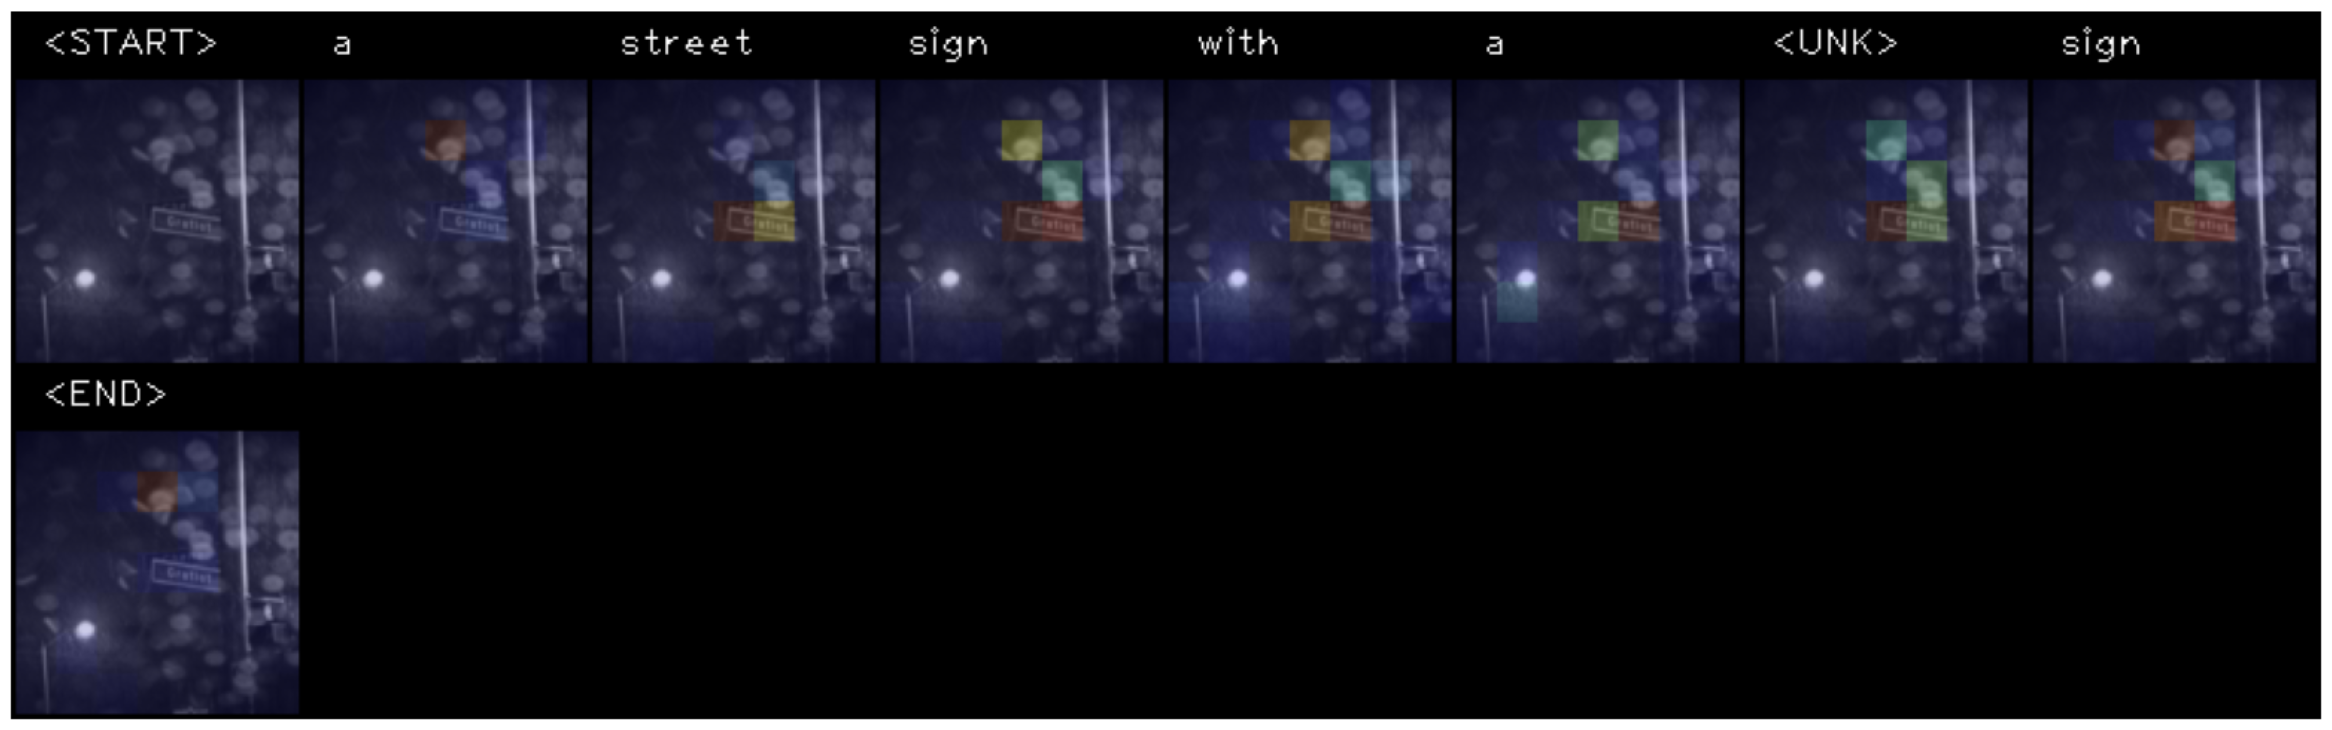

In [ ]:
def attention_visualizer(img, attn_weights, token):
    """
    Visuailze the attended regions on a single frame from a single query word.
    Inputs:
    - img: Image tensor input, of shape (3, H, W)
    - attn_weights: Attention weight tensor (7, 7)
    - token: The token string you want to display above the image

    Outputs:
    - img_output: Image tensor output, of shape (3, H+25, W)

    """
    C, H, W = img.shape
    assert C == 3, "We only support image with three color channels!"
    img_copy = img.float().div(255.0).permute(1, 2, 0).numpy()[:, :, ::-1].copy()

    ################# Your Implementations #################################
    # TODO: Visualize the attended regions on a single frame from a single query word.
    # (1) Reshape attention weights to (H, W) using nearest neighbor interpolation
    # (2) Normalize the attention weights to [0, 1]
    # (3) Apply a color map to the attention weights using cv2.applyColorMap
    # (4) Convert the original image to grayscale for clearer visualization
    # (5) Combine the image and the attention map using cv2.addWeighted

    masked_img = None


    ################# End of your Implementations ##########################

    img_copy = np.concatenate((np.zeros((25, W, 3)), masked_img), axis=0)

    # Add text
    cv2.putText(
        img_copy,
        "%s" % (token),
        (10, 15),
        cv2.FONT_HERSHEY_PLAIN,
        1.0,
        (255, 255, 255),
        thickness=1,
    )

    return img_copy



In [ ]:
from torchvision.utils import make_grid

for split in ["train", "val"]:
    sample_idx = torch.randint(
        0, num_train if split == "train" else num_val, (4,)
    )
    sample_images = data_dict[split + "_images"][sample_idx]
    sample_captions = data_dict[split + "_captions"][sample_idx]

    model.eval()
    generated_captions, attn_weights_all = sample_rnn(model, sample_images.to(device))
    generated_captions = decode_captions(
        generated_captions, data_dict["vocab"]["idx_to_token"]
    )

    for i in range(4):
        tokens = generated_captions[i].split(" ")

        vis_attn = []
        for j in range(len(tokens)):
            img = sample_images[i]
            attn_weights = attn_weights_all[i][j]
            token = tokens[j]
            img_copy = attention_visualizer(img, attn_weights, token)
            vis_attn.append(transforms.ToTensor()(img_copy))

        plt.rcParams["figure.figsize"] = (20.0, 20.0)
        vis_attn = make_grid(vis_attn, nrow=8)
        plt.imshow(torch.flip(vis_attn, dims=(0,)).permute(1, 2, 0))
        plt.axis("off")
        plt.show()
        plt.rcParams["figure.figsize"] = (10.0, 8.0)

In 2-3 sentences, discuss what have you observed from the visualized attention weights?

(Double click to edit)

Your Answer:

---


----
## Q2. Diffusion Model (50 pts)

A (denoising) diffusion model isn't that complex if you compare it to other generative models such as Normalizing Flows, GANs or VAEs: they all convert noise from some simple distribution to a data sample. This is also the case here where **a neural network learns to gradually denoise data** starting from pure noise.

In a bit more detail for images, the set-up consists of 2 processes:
* a **fixed** (or predefined) forward diffusion process $q$ of our choosing, that gradually adds Gaussian noise to an image, until you end up with pure noise
* a **learned** reverse denoising diffusion process $p_\theta$, where a neural network is trained to gradually denoise an image starting from pure noise, until you end up with an actual image.

<p align="center">
    <img src="https://drive.google.com/uc?id=1t5dUyJwgy2ZpDAqHXw7GhUAp2FE5BWHA" width="600" />
</p>

Both the forward and reverse process indexed by $t$ happen for some number of finite time steps $T$. You start with $t=0$ where you sample a real image $\mathbf{x}_0$ from your data distribution (let's say an image of a cat from ImageNet), and the forward process samples some noise from a Gaussian distribution at each time step $t$, which is added to the image of the previous time step. Given a sufficiently large $T$ and a well behaved schedule for adding noise at each time step, you end up with what is called an [isotropic Gaussian distribution](https://math.stackexchange.com/questions/1991961/gaussian-distribution-is-isotropic) at $t=T$ via a gradual process.

Let's write this down more formally, as ultimately we need a tractable loss function which our neural network needs to optimize.

Let $q(\mathbf{x}_0)$ be the real data distribution, say of "real images". We can sample from this distribution to get an image, $\mathbf{x}_0 \sim q(\mathbf{x}_0)$. We define the forward diffusion process $q(\mathbf{x}_t | \mathbf{x}_{t-1})$ which adds Gaussian noise at each time step $t$, according to a known variance schedule $0 < \beta_1 < \beta_2 < ... < \beta_T < 1$ as
$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathbf{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I}).
$$

Recall that a normal distribution (also called Gaussian distribution) is defined by 2 parameters: a mean $\mu$ and a variance $\sigma^2 \geq 0$. Basically, each new (slightly noiser) image at time step $t$ is drawn from a **conditional Gaussian distribution** with $\mathbf{\mu}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1}$ and $\sigma^2_t = \beta_t$, which we can do by sampling $\mathbf{\epsilon} \sim \mathbf{N}(\mathbf{0}, \mathbf{I})$ and then setting $\mathbf{x}_t = \sqrt{1 - \beta_t} \mathbf{x}_{t-1} +  \sqrt{\beta_t} \mathbf{\epsilon}$.

Note that the $\beta_t$ aren't constant at each time step $t$ (hence the subscript) --- in fact one defines a so-called **"variance schedule"**, which can be linear, quadratic, cosine, we will be using linear variance schedule in this assignment.

So starting from $\mathbf{x}_0$, we end up with $\mathbf{x}_1,  ..., \mathbf{x}_t, ..., \mathbf{x}_T$, where $\mathbf{x}_T$ is pure Gaussian noise if we set the schedule appropriately.

Now, if we knew the conditional distribution $p(\mathbf{x}_{t-1} | \mathbf{x}_t)$, then we could run the process in reverse: by sampling some random Gaussian noise $\mathbf{x}_T$, and then gradually "denoise" it so that we end up with a sample from the real distribution $\mathbf{x}_0$.

However, we don't know $p(\mathbf{x}_{t-1} | \mathbf{x}_t)$. It's intractable since it requires knowing the distribution of all possible images in order to calculate this conditional probability. Hence, we're going to leverage a neural network to **approximate (learn) this conditional probability distribution**, let's call it $p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t)$, with $\theta$ being the parameters of the neural network, updated by gradient descent.

Ok, so we need a neural network to represent a (conditional) probability distribution of the backward process. If we assume this reverse process is Gaussian as well, then recall that any Gaussian distribution is defined by 2 parameters:
* a mean parametrized by $\mu_\theta$;
* a variance parametrized by $\Sigma_\theta$;

so we can parametrize the process as
$$ p_\theta (\mathbf{x}_{t-1} | \mathbf{x}_t) = \mathbf{N}(\mathbf{x}_{t-1}; \mu_\theta(\mathbf{x}_{t},t), \Sigma_\theta (\mathbf{x}_{t},t))$$
where the mean and variance are also conditioned on the noise level $t$.

For more detailed mathematical analysis of diffusion models, refer to this wonderful [blog post](https://lilianweng.github.io/posts/2021-07-11-diffusion-models).

Our implementation would be based on one of the most influential papers of diffusion models [DDPM](https://arxiv.org/abs/2006.11239) by Ho. et al., feel free to also check the original paper. Note that the field of diffusion models is evolving rapidaly in recent years with a lot tips of tricks, and we will explore one state-of-the-art diffusion model [StableDiffusion](https://stability.ai/) in Q1.4.


Here we use the classical MNIST dataset. MNIST consists of images with hand-written digits from 0 to 9, which is the most well-known benchmark for image classification and generation tasks. We apply random horizontal flips and rescaling and on the input images to make them have values in the $[-1,1]$ range. We use random horizontal flips during training to improve sample quality slightly.

In [ ]:
from torchvision.datasets import MNIST

image_size = 32
channels = 1
batch_size = 128

# define image transformations (e.g. using torchvision)
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Lambda(lambda t: (t * 2) - 1)
])

# load dataset from the hub
dataset = MNIST(root=f"{CS163_path}/MNIST", transform=transform, download=True)

# create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

### Q2.1: Forward process = Noise scheduler (10 pts)
We first need to build the inputs for our model, which are more and more noisy images. Instead of doing this sequentially, we can use the closed form to calculate the image for any of the timesteps individually.

A nice property of the above process is that we can sample $\mathbf{x}_t$ at any arbitrary time step $t$ in a closed form using reparameterization trick.

Let $\alpha_t = 1 - \beta_t$ and $\bar{\alpha}_t = \prod_{i=1}^t \alpha_i$:
$$ \begin{aligned} \mathbf{x}_t &= \sqrt{\alpha_t}\mathbf{x}_{t-1} + \sqrt{1 - \alpha_t}\boldsymbol{\epsilon}_{t-1} \text{; where} \ \boldsymbol{\epsilon}_{t-1}, \boldsymbol{\epsilon}_{t-2}, \dots \sim \mathbf{N}(\mathbf{0}, \mathbf{I}) \\
&= \sqrt{\alpha_t \alpha_{t-1}} \mathbf{x}_{t-2} + \sqrt{1 - \alpha_t \alpha_{t-1}} \bar{\boldsymbol{\epsilon}}_{t-2} \text{ ;where } \bar{\boldsymbol{\epsilon}}_{t-2} \text{ merges two Gaussians (*).} \\
&= \dots = \sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}
\\
\text{Hence, }q(\mathbf{x}_t \vert \mathbf{x}_0) = \mathbf{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t)\mathbf{I}) \end{aligned} $$



(*) Recall that when we merge two Gaussians with different variance, $\mathbf{N}(\mathbf{0}, \sigma_1^2\mathbf{I})$ and $\mathbf{N}(\mathbf{0}, \sigma_2^2\mathbf{I})$, the new distribution is $\mathbf{N}(\mathbf{0}, (\sigma_1^2 + \sigma_2^2)\mathbf{I})$. Here the merged standard deviation is $\sqrt{(1 - \alpha_t) + \alpha_t (1-\alpha_{t-1})} = \sqrt{1 - \alpha_t\alpha_{t-1}}$.

Usually, we can afford a larger update step when the sample gets noisier, so $\beta_1 \lt \beta_2 \le \dots \lt \beta_T$ and therefore $\bar{\alpha}_1 \gt \dots \gt \bar{\alpha}_T$.

**Key Takeaways**:
- The noise-levels/variances can be pre-computed
- There are different types of variance schedules
- We can sample each timestep image independently (Sums of Gaussians is also Gaussian)
- No model is needed in this forward step

Let's implement the forward process in the code blocks below:

In [ ]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start


def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)


# Define beta schedule
# Feel free to try other T and schedulers
T = 300
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
################# Your Implementations #########################################
# TODO: precompute the following variables using the above equations
alphas =
alphas_cumprod =
sqrt_alphas_cumprod =
sqrt_one_minus_alphas_cumprod =
################# End of your Implementations ##################################


def get_index_from_list(vals, t):
    """
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension.
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, 1, 1, 1).to(t.device)


@torch.no_grad()
def forward_diffusion_sample(x_0, t):
    """
    Perform the forward diffusion process
    x0: input image of shape [B, C, H, W]
    t: input timesteps of shape [B]
    use the provided "get_index_from_list" function to get values at timestep t
    returns:
    x_t: noisy image at time step t of shape [B, C, H, W]
    noise: the generated gaussian noise
    """
    x_t = None
    noise = None
    ################# Your Implementations #####################################








    ################# End of your Implementations ##############################
    return x_t, noise

Let's test it on our dataset.
If your implentation is correct, you should see the image is gradually becoming noiser and becomes a complete random noise in the final steps.

In [ ]:
def show_tensor_image(image, title):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)),  # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.axis("off")
    plt.title(title)
    image = torch.clamp(image, -1.0, 1.0)
    plt.imshow(reverse_transforms(image), cmap="gray", interpolation='none')


# Simulate forward diffusion
image = next(iter(dataloader))[0]
plt.figure(figsize=(15, 15))
plt.axis('off')
num_images = 10 + 1
stepsize = int(T / (num_images - 1))
plt.subplot(1, num_images + 1, 1)
show_tensor_image(image, "GT")
for idx in range(0, T, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images + 1, int(idx / stepsize) + 2)
    img, noise = forward_diffusion_sample(image, t)
    show_tensor_image(img, f"step={t.item()}")

### Q2.2: Backward process = U-Net (15 pts)





Empirically, DDPM found that training objective of the diffusion model $\mu_\theta(\mathbf{x}_{t},t), \Sigma_\theta (\mathbf{x}_{t},t)$ is equivalent to predicting the noise $\epsilon_\theta(\mathbf{x}_{t},t)$ at timestamp t, which is easier for the model to learn i.e.,  

$$
\begin{aligned}
L &= \mathbb{E}_{t \sim [1, T], \mathbf{x}_0, \boldsymbol{\epsilon}_t}[|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\mathbf{x}_t, t)|^2 ]
\\  
&= \mathbb{E}_{t \sim [1, T], \mathbf{x}_0, \boldsymbol{\epsilon}_t} [|\boldsymbol{\epsilon}_t - \boldsymbol{\epsilon}_\theta(\sqrt{\bar{\alpha}_t}\mathbf{x}_0 + \sqrt{1 - \bar{\alpha}_t}\boldsymbol{\epsilon}_t, t)|^2 ]
\end{aligned}
$$

We can use a U-Net model to model the noise $\epsilon_\theta(\mathbf{x}_{t},t)$.

The training algorithm now looks as follows:


<p align="center">
    <img src="https://drive.google.com/uc?id=1LJsdkZ3i1J32lmi9ONMqKFg5LMtpSfT4" width="400" />
</p>

In other words:
* we take a random sample $\mathbf{x}_0$ from the real unknown and possibily complex data distribution $q(\mathbf{x}_0)$
* we sample a noise level $t$ uniformally between $1$ and $T$ (i.e., a random time step)
* we sample some noise from a Gaussian distribution and corrupt the input by this noise at level $t$ using the nice property defined above
* the neural network is trained to predict this noise based on the corruped image $\mathbf{x}_t$, i.e. noise applied on $\mathbf{x}_0$ based on known schedule $\beta_t$

In reality, all of this is done on batches of data as one uses stochastic gradient descent to optimize neural networks.

**Key Takeaways**:
- We use a simple form of a UNet for to predict the noise in the image
- The input is a noisy image, the output is the **noise** in the image
- Because the parameters are shared accross time, we need to tell the network in which timestep we are
- The timestep is encoded by the transformer Sinusoidal Embedding

U-Net consists of a bottleneck in the middle that makes sure the network learns only the most important information. Importantly, it introduced residual connections between the encoder and decoder, greatly improving gradient flow (inspired by ResNet). The architecture of the U-Net would be as follows:

<p align="center">
    <img src="https://drive.google.com/uc?id=1_Hej_VTgdUWGsxxIuyZACCGjpbCGIUi6" width="600" />
</p>

As can be seen, a U-Net model first downsamples the input (i.e. makes the input smaller in terms of spatial resolution), after which upsampling is performed. The above figure is just for your reference, please follow the code instructions below and implement a simple U-Net.


In [ ]:
class Block(nn.Module):
    """
    A baisc U-Net block.
    """

    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 2, 2, 0)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.MaxPool2d(2, 2, 0)

        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):

    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(
            torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """

    def __init__(self):
        super().__init__()
        image_channels = channels
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = channels
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim), nn.ReLU())

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        ################# Your Implementations #################################
        # TODO: initialize the u-net
        # 1. Define downsample blocks according to down_channels
        # 2. Define upsample blocks according to up_channels
        # Hint: Use torch.nn.ModuleList instead of the standard python list to
        #       ensure that your blocklist will be stored properly as nn.Module

        ################# End of your Implementations ##########################

        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        ################# Your Implementations #################################
        # 1. Downsample, store intermediate features to residual_inputs
        # 2. Concat the outputs with the intermediate features stored in residual_input, then Upsample

        ################# End of your Implementations ##########################
        return self.output(x)

In the following code block, implement the loss function between the target noise and the predicted noise

In [ ]:
def get_loss(model, x_0, t):
    """
    x_0: initial image without noise [B, C, H, W]
    t: timestamp [B]
    """
    loss = None
    ################# Your Implementations #####################################
    # 1. Perform forward diffusion process to get the target noise and the noisy image
    # 2. Perform denoising step on the noisy image to get the predicted noise from the model
    # 3. Compute the loss from the predicted and the the target noise
    # 4. You could experiment with both l1 and l2 losses, in practice, l1 loss gives better quality, while l2 loss gives more diversity

    ################# End of your Implementations ##############################
    return loss

### Q2.3: Sampling (10 pts)



Sampling is summarized in DDPM as Algorithm 2:

<img src="https://drive.google.com/uc?id=1ij80f8TNBDzpKtqHjk_sh8o5aby3lmD7" width="500" />

Generating new images from a diffusion model happens by reversing the diffusion process: we start from $T$, where we sample pure noise from a Gaussian distribution, and then use our neural network to gradually denoise it (using the conditional probability it has learned), until we end up at time step $t = 0$. As shown above, we can derive a slighly less denoised image $\mathbf{x}_{t-1 }$ by plugging in the reparametrization of the mean, using our noise predictor. Remember that the variance is known ahead of time.

Ideally, we end up with an image that looks like it came from the real data distribution.

Following Algorithm 2, implement the sampling procedure below.


In [ ]:
@torch.no_grad()
def sample_timestep(model, x, t):
    """
    Calls the model to predict the noise in the image and returns
    the denoised image.
    x: input image at timestamp t [B, C, H, W]
    t: the timestamp [B]
    """
    x_denoised = None
    ################# Your Implementations #####################################
    # 1. Calculate the predicted noise at timestamp t with the trained model
    # 2. Denoise the image at timestamp t with the predicted noise according to the above algorithm
    # 3. If we are not in the last step yet, apply random gaussian noise to the denoised image to get the image at timestamp t-1.
    # Note that the algorithm starts at t=1, and in our implementation we start at t=0

    ################# End of your Implementations ##############################
    return x_denoised


@torch.no_grad()
def sample_plot_image():
    # Sample noise
    model.eval()
    img = torch.randn((1, channels, image_size, image_size), device=device)
    plt.figure(figsize=(15, 15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T / num_images)

    for i in range(0, T)[::-1]:
        t = torch.full((1, ), i, device=device, dtype=torch.long)
        img = sample_timestep(model, img, t)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i / stepsize) + 1)
            show_tensor_image(img.detach().cpu(), f"step={t.item()}")
    plt.show()
    model.train()

Now we have finished all components required to train diffusion models, it's time to train our model on the MNIST dataset!

In [ ]:
# feel free to try different seeds
seed_everything(0)

model = SimpleUnet()
model.to(device)

# feel free to try other optimizers, lrs and epochs
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 5

for epoch in range(epochs):
    with tqdm(total=len(dataloader),
              desc=f'Epoch {epoch + 1}/{epochs}',
              position=0,
              leave=True) as pbar:
        for step, batch in enumerate(dataloader):
            images = batch[0]
            images = images.to(device)
            if step == 0:
                sample_plot_image()
            optimizer.zero_grad()

            t = torch.randint(0, T, (images.shape[0], ), device=device).long()
            loss = get_loss(model, images, t)
            loss.backward()
            optimizer.step()
            pbar.update(1)
            pbar.set_postfix(loss=loss.item())

If your implementation is correct, the training loss should go down to about 0.12 after 5 epochs. You may want to generate more samples from the trained model to check its  diversity and quality. For example, I got the following generated "3" with my model. You can sample several times and leave the one that you're most satisfied with.


<img src="https://drive.google.com/uc?id=1OUcJ0P798XaDnp8XnU8U2EycA41SCXYN" width="800" />

In [ ]:
sample_plot_image()

### Q2.4 State-of-the-art Diffusion Models (10 pts)

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. This model uses a frozen CLIP ViT-L/14 text encoder to condition the model on text prompts. With its 860M UNet and 123M text encoder, the model is relatively lightweight and can run on many consumer GPUs.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

In this question, let's see how to use Stable Diffusion with the Hugging Face [Diffusers library](https://github.com/huggingface/diffusers).


In [ ]:
!pip install diffusers
!pip install transformers accelerate

Stable Diffusion is based on a particular type of diffusion model called **Latent Diffusion**, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752). Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference.





<br>

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.**

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

We already implemented the U-Net in the previous questions.

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

Inspired by [Imagen](https://imagen.research.google/), Stable Diffusion does **not** train the text-encoder during training and simply uses an CLIP's already trained text encoder, [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8. This means that an image of shape `(3, 512, 512)` becomes `(3, 64, 64)` in latent space, which requires `8 × 8 = 64` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

**Stable Diffusion during inference**

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. In the previous questions, we have implemented the [DDPM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddpm.py) in our simple diffusion model. For Stable Diffusion, we will use [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py).

Theory on how the scheduler algorithm function is out of scope for this assignment, but in short one should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated *ca.* 50 times to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.



After this brief introduction to Latent and Stable Diffusion, let's get into the code!

We will start by loading the individual models involved.

The [pre-trained model](https://huggingface.co/CompVis/stable-diffusion-v1-3-diffusers/tree/main) includes all the components required to setup a complete diffusion pipeline. They are stored in the following folders:
- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained`.

In [ ]:
from diffusers import AutoencoderKL, PNDMScheduler, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer

# 1. Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4",
                                    subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4",
                                            subfolder="unet")

Now we define the scheduler for the denoising process using the PNDM scheduler.

In [ ]:
scheduler = PNDMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4",
                                          subfolder="scheduler")

Next we move the models to the GPU.

In [ ]:
vae = vae.to(device)
text_encoder = text_encoder.to(device)
unet = unet.to(device)

We now define the parameters we'll use to generate images.

`prompt` defines the text that the generation is conditioned on.

`heigt` and `width` are the default size of the image during training so there's no need for modification.

`num_inference_steps` defines the total number of denoising steps.

`guidance_scale` is a way to increase the adherence to the conditional signal which in this case is text as well as overall sample quality. It forces the generation to better match with the prompt. Numbers like 7 or 8.5 give good results, if you use a very large number the images might look good, but will be less diverse.

`generator` defines the seed that we would like to use when creating the initial random noise, which can be crucial for the generation results as well.

In [ ]:
################# Your Implementations #########################################
#TODO: play with the prompt, inference_steps, guidance scales and seed
prompt = ["a photograph of an astronaut riding a horse"
          ]  # try different prompts

height = 512  # default height of Stable Diffusion
width = 512  # default width of Stable Diffusion

num_inference_steps = 100  # try numbers like 1, 10, 50

guidance_scale = 7.5  # try numbers like 0, 1, 75

generator = torch.manual_seed(32)  # try different seeds as well

################# End of Your Implementations ##################################

batch_size = 1

First, we get the text_embeddings for the prompt. These embeddings will be used to condition the UNet model.

In [ ]:
text_input = tokenizer(prompt,
                       padding="max_length",
                       max_length=tokenizer.model_max_length,
                       truncation=True,
                       return_tensors="pt")

with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(device))[0]

We'll also get the unconditional text embeddings for classifier-free guidance, which are just the embeddings for the padding token (empty text). They need to have the same shape as the conditional `text_embeddings` (`batch_size` and `seq_length`)

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer([""] * batch_size,
                         padding="max_length",
                         max_length=max_length,
                         return_tensors="pt")
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(device))[0]

For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Generate the intial random noise. That is similar to what we have done before, except that in StableDiffusion we directly generate the noise in the latent space instead of the image space.

In [ ]:
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
)
latents = latents.to(device)

The model will transform this latent representation (pure noise) into a `512 × 512` image later on.

Next, we initialize the scheduler with our chosen `num_inference_steps`.
This will compute the `sigmas` and exact time step values to be used during the denoising process.

In [ ]:
scheduler.set_timesteps(num_inference_steps)

We are ready to write the denoising loop.

In [ ]:
for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input,
                          t,
                          encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text -
                                                       noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample

We now use the `vae` to decode the generated `latents` back into the image.

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
    image = vae.decode(latents).sample

And finally, let's convert the image to PIL so we can display or save it.

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

Play around with the different hyperparameters of StableDiffusion including the `prompt`, `num_inference_steps`, `guidance_scale`, and `generator`, describe how the generated image would change based on the hyperparametes, feel free to add some code blocks below to show your generated images.

(Double click to edit)

Your Answer:

---

### Q2.5 Discussion (5 pts)

In 2-3 sentences, explain why people often use autoregressive models for text generation and diffusion models for image generation?


(Double click to edit)

Your Answer:

---